In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette('Dark2')
sns.set_style({'axes.axisbelow': True, 'axes.edgecolor': '.15', 'axes.facecolor': 'white',
               'axes.grid': True, 'axes.labelcolor': '.15', 'axes.linewidth': 1.25, 
               'figure.facecolor': 'white', 'font.family': ['sans-serif'], 'grid.color': '.15',
               'grid.linestyle': ':', 'grid.alpha': .5, 'image.cmap': 'Greys', 
               'legend.frameon': False, 'legend.numpoints': 1, 'legend.scatterpoints': 1,
               'lines.solid_capstyle': 'round', 'axes.spines.right': False, 'axes.spines.top': False,  
               'text.color': '.15',  'xtick.top': False, 'ytick.right': False, 'xtick.color': '.15',
               'xtick.direction': 'out', 'xtick.major.size': 6, 'xtick.minor.size': 3,
               'ytick.color': '.15', 'ytick.direction': 'out', 'ytick.major.size': 6,'ytick.minor.size': 3})
sns.set_context('paper')

#http://phyletica.org/matplotlib-fonts/
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
from snapanalysis.config import OUTPUT_DIRECTORY as MAIN_OUTPUT_DIRECTORY
OUTPUT_DIRECTORY = os.path.join(MAIN_OUTPUT_DIRECTORY, 'ptm-response')

if not os.path.isdir(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)
    
def output_path(basename):
    return os.path.join(OUTPUT_DIRECTORY, basename)

In [3]:
import importlib
import helpers
importlib.reload(helpers)
from helpers import *

In [4]:
from snapanalysis.models.ptm_response.main import FDR_THRESHOLD_RESPONSE, FC_THRESHOLD_RESPONSE
from snapanalysis.models.ptm_response.main import PREDICTOR_ORDER

In [5]:
palette_ptms = {
    'h2az': '#584A87',
    'me1': '#BBE1BB',
    'me2': '#9FBA7D',
    'me3': '#6F9979',
    'm5c': '#85B3B2',
    'ac': '#40678E'
}

palette = {
   'H2A.Z': palette_ptms['h2az'],
   'DNA Methylation': palette_ptms['m5c'],
}
for predictor in PREDICTOR_ORDER:
    
    if predictor.endswith('ac'):
        palette[predictor] = palette_ptms['ac']
    elif predictor[-3:] in ['me1', 'me2', 'me3']:
        palette[predictor] = palette_ptms[predictor[-3:]]


In [6]:
def human_label(row):
    
    if not row['significant']:
        return 'n.s.'
    elif row['significant_and_large_fc']:
        if row['logFC'] > 0:
            return f'≥ {FC_THRESHOLD_RESPONSE}'
        elif row['logFC'] < 0:
            return f'≤ -{FC_THRESHOLD_RESPONSE}'
    else:
        if row['logFC'] > 0:
            return f'0 to {FC_THRESHOLD_RESPONSE}'
        else:
            return f'-{FC_THRESHOLD_RESPONSE} to 0'

    

In [7]:
data_full = load_limma_data()
data_full['Effect'] = data_full.apply(human_label, axis=1)

In [8]:
data_full['Effect'].value_counts()

n.s.         19819
0 to 1.0      1277
-1.0 to 0      693
≥ 1.0          457
≤ -1.0         120
Name: Effect, dtype: int64

In [9]:
count_matrix = data_full.reset_index().groupby(['predictor', 'Effect']).size().unstack('Effect').fillna(0).astype(int)
count_matrix = count_matrix.reindex(PREDICTOR_ORDER, 
                                    ['≤ -1.0', '-1.0 to 0', 
                                     'n.s.', 
                                     '0 to 1.0', '≥ 1.0'])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Interpreting call
	'.reindex(a, b)' as 
	'.reindex(index=a, columns=b)'.
Use named arguments to remove any ambiguity. In the future, using positional arguments for 'index' or 'columns' will raise  a 'TypeError'.
  """


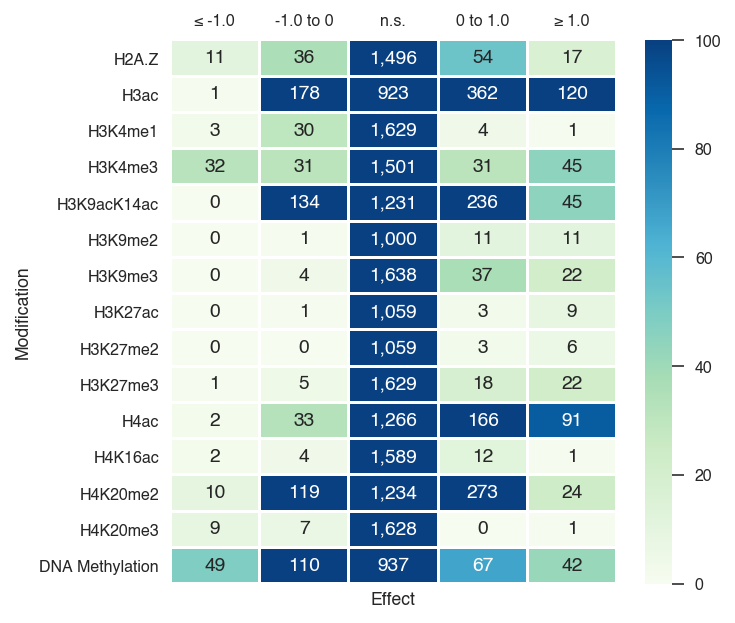

In [10]:
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()
sns.heatmap(count_matrix, cmap='GnBu', vmax=100, fmt=',', annot=True, ax=ax, linewidth=1)

ax.yaxis.set_tick_params(length=0)

ax.xaxis.tick_top()
ax.xaxis.set_tick_params(length=0)

ax.set_ylabel('Modification')


plt.savefig(os.path.join(OUTPUT_DIRECTORY, 'significant-counts.pdf'), bbox_inches='tight')

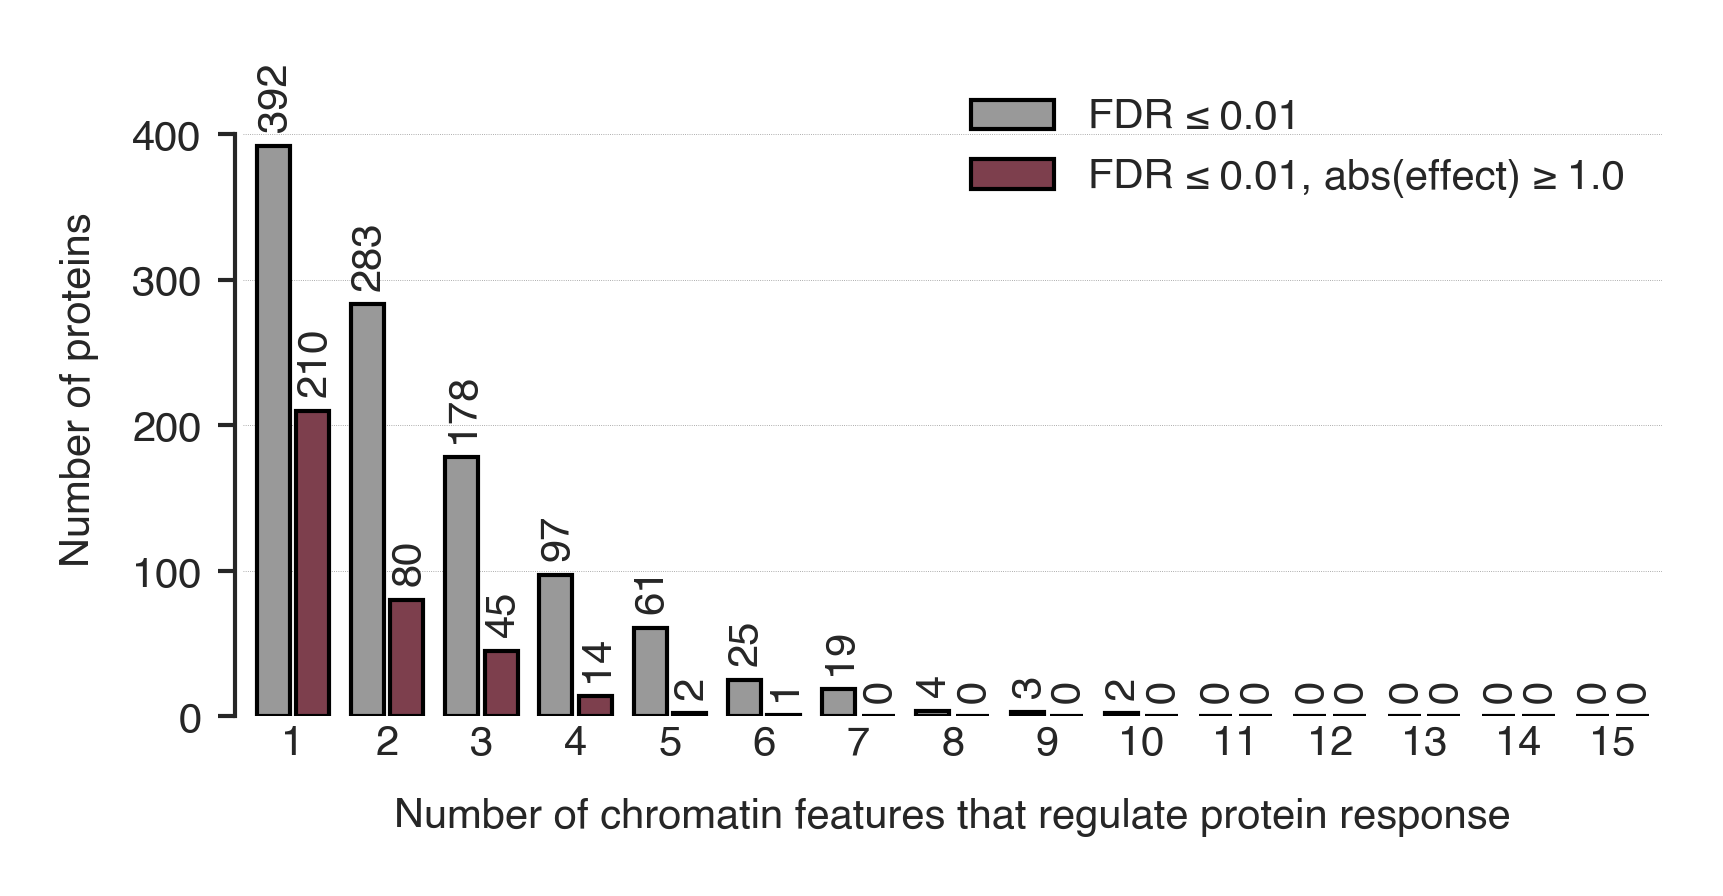

In [101]:
from matplotlib import gridspec




df = data_full[['significant', 'significant_and_large_fc']].fillna(False)
df = df.groupby(level='Gene label')['significant', 'significant_and_large_fc'].sum()
df = df.astype(int)

n_predictors = data_full.index.get_level_values('predictor').nunique()

significant_vcs = df['significant'].value_counts()
significant_and_large_fc_vcs = df['significant_and_large_fc'].value_counts()

# Reindex removing n=0, n=0 is inaccurate anyway as `data_full` lacks some proteins that were
# not considered for modelling.

count_range = list(range(1, n_predictors+1))

significant_vcs = significant_vcs.reindex(count_range).fillna(0)
significant_and_large_fc_vcs = significant_and_large_fc_vcs.reindex(significant_vcs.index).fillna(0)



labelsize = 5

context = {
            'axes.linewidth': 0.5,
            'grid.linewidth': 0.1,
            'grid.linestyle': ':',
            'xtick.labelsize': labelsize,
            'ytick.labelsize': labelsize,
            'xtick.major.size': 0,
            'xtick.major.width': 0.5,
            'xtick.major.pad': 1,
            'xtick.minor.size': 1.5,
            'xtick.minor.width': 0.2,
            'xtick.minor.pad': 2,

            'ytick.major.size': 2,
            'ytick.major.width': 0.5,
            'ytick.major.pad': 2,
            'ytick.minor.size': 1.5,
            'ytick.minor.width': 0.2,
            'ytick.minor.pad': 2,
        }

with sns.plotting_context(context):

    fig = plt.figure(
        figsize=(2.75591, 1.37795), #70mm x 35mm
        dpi=300,
        constrained_layout=True,
    )

    gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

    ax_significant = fig.add_subplot(gs[0, 0])
    # ax_significant_and_large_fc = fig.add_subplot(gs[0, 1], sharex=ax_significant, sharey=ax_significant)

    barplot_width = 0.35
    barplot_kwargs = dict(width=barplot_width, edgecolor='black', linewidth=0.5)
    
    barplot_offset = (barplot_width / 2)*1.2
    ax_significant.bar(significant_vcs.index - barplot_offset, significant_vcs.values, 
                       label=f"FDR ≤ {FDR_THRESHOLD_RESPONSE}",
                       color='#999999', **barplot_kwargs)
    ax_significant.bar(significant_and_large_fc_vcs.index + barplot_offset, significant_and_large_fc_vcs.values, 
                       label=f"FDR ≤ {FDR_THRESHOLD_RESPONSE}, abs(effect) ≥ {FC_THRESHOLD_RESPONSE}",
                       color='#7D3F4D', **barplot_kwargs)
    
    for i, value in significant_vcs.items():
        # The +(barplot_offset * 0.1) bit corrects for some weird alignment issue
        ax_significant.text(i-barplot_offset+(barplot_offset * 0.1), value+10, '{:,}'.format(int(value)), 
                            rotation=90, 
                            ha='center', va='bottom',
                            fontsize=labelsize)
    
    for i, value in significant_and_large_fc_vcs.items():
        ax_significant.text(i+barplot_offset+(barplot_offset * 0.1), value+10, '{:,}'.format(int(value)), 
                            rotation=90, 
                            ha='center', va='bottom',
                            fontsize=labelsize)

    ax_significant.set_xticks(count_range)
    ax_significant.set_xticklabels(count_range)
    ax_significant.xaxis.grid(False)
    
    ax_significant.legend(fontsize=labelsize)
    
    ax_significant.set_xlabel("Number of chromatin features that regulate protein response", fontsize=labelsize)
    ax_significant.set_ylabel("Number of proteins", fontsize=labelsize)
    
    ax_significant.set_xlim(count_range[0]-barplot_width*1.5, count_range[-1]+barplot_width*1.5)
    
    ax_significant.set_yticks([0, 100, 200, 300, 400])
    
    ax_significant.set_ylim(0, 450)
    
    
    sns.despine(ax=ax_significant, offset=1, bottom=True, trim=True)
    
    plt.savefig(os.path.join(OUTPUT_DIRECTORY, 'significant-counts-histogram.pdf'), dpi=300)


In [38]:
significant_vcs.sum()

1837.0

In [39]:
significant_and_large_fc_vcs.sum()

1837.0